In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pickle
import os, random
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
tf.config.set_visible_devices([], 'GPU')

In [2]:
home = '/Users/kamil/Library/CloudStorage/OneDrive-AkademiaGórniczo-Hutniczaim.StanisławaStaszicawKrakowie/Programming/Data/tsd'
result_preprocessed_name = "data_preprocessed.pickle"
result_original_name = "data_original.pickle"
train_name = "train.pickle"
test_name = "test.pickle"
valid_name = "valid.pickle"

In [28]:
def decode_one_hot(one_hot):
    return np.where(one_hot == 1)[0][0]

In [3]:
def count_classes(y, labels):
    counts = {}
    for c in set(y):
        counts[labels[c]] = len(y[y==c])
    return counts

In [33]:
def count_classes_one_hot(one_hot, labels):
    counts = {}
    for c in range(len(labels)):
        count = 0
        for oh in one_hot:
            if decode_one_hot(oh) == c:
                count += 1
        counts[labels[c]] = count
    return counts

In [4]:
def show_samples(shape, data):
    assert shape[0] > 1 and shape[1] >1
    
    height = 4*shape[0]
    width = 4*shape[1]
    
    f, ax = plt.subplots(shape[0], shape[1])
    f.set_size_inches(width, height)
    for y in range(shape[0]):
        for x in range(shape[1]):
            index = random.randint(0, len(data))
            ax[y][x].imshow(data[index])

In [5]:
def img_info(img):
    print("Shape:", img.shape)
    print("Dtype:", img.dtype)
    print("Min:", np.min(img))
    print("Max:", np.max(img))

In [6]:
def lab_eq(img, clahe):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    lab_planes = list(cv2.split(lab))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

In [7]:
def hsv_eq(img, clahe):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = hsv[:, :, 0], hsv[:, :, 1], hsv[:, :, 2]
    v = clahe.apply(v)
    hsv = np.dstack((h, s, v))
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)    

In [8]:
def preprocess(img, eq):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return eq(img, clahe).astype('float32') / 255.0        

In [9]:
def apply(imgs, eq):
    result = []
    for img in imgs:
        result.append(preprocess(img, eq))
    return np.array(result)

### Reading raw data

In [10]:
train = pd.read_pickle(os.path.join(home, train_name))
test = pd.read_pickle(os.path.join(home, test_name))
valid = pd.read_pickle(os.path.join(home, valid_name))
labels = ['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']

In [11]:
x = []
x.extend(train['features'])
x.extend(test['features'])
x.extend(valid['features'])
x = np.array(x)

y = []
y.extend(train['labels'])
y.extend(test['labels'])
y.extend(valid['labels'])
y = np.array(y)

### Augmentation

In [13]:
def create_equal_classes(x, y, count, augmentation):
    new_x = []
    new_y = []
    for c in set(y):
        data = x[y==c]
        indices = random.sample(range(len(data)), min(len(data), count))
        chosen = data[indices]
        new_x.extend(chosen)
        for i in range(len(chosen)):
            new_y.append(c)
            
        size = len(chosen)
        while size < count:
            index = random.randint(0, len(chosen)-1)
            new_x.append(np.array(augmentation(chosen[index])).astype('uint8'))
            new_y.append(c)
            size += 1
            
    return np.array(new_x), np.array(new_y)

In [14]:
def split(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=8000)
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=5000)
    return x_train, y_train, x_test, y_test, x_valid, y_valid

In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.04),
    tf.keras.layers.RandomZoom(0.07),
    tf.keras.layers.RandomTranslation(0.03, 0.03),
    tf.keras.layers.RandomBrightness(0.03)
])
new_x, new_y = create_equal_classes(x, y, 2000, data_augmentation)

2023-02-24 01:13:47.444207: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [16]:
count_classes(new_y, labels)

{'Speed limit (20km/h)': 2000,
 'Speed limit (30km/h)': 2000,
 'Speed limit (50km/h)': 2000,
 'Speed limit (60km/h)': 2000,
 'Speed limit (70km/h)': 2000,
 'Speed limit (80km/h)': 2000,
 'End of speed limit (80km/h)': 2000,
 'Speed limit (100km/h)': 2000,
 'Speed limit (120km/h)': 2000,
 'No passing': 2000,
 'No passing for vehicles over 3.5 metric tons': 2000,
 'Right-of-way at the next intersection': 2000,
 'Priority road': 2000,
 'Yield': 2000,
 'Stop': 2000,
 'No vehicles': 2000,
 'Vehicles over 3.5 metric tons prohibited': 2000,
 'No entry': 2000,
 'General caution': 2000,
 'Dangerous curve to the left': 2000,
 'Dangerous curve to the right': 2000,
 'Double curve': 2000,
 'Bumpy road': 2000,
 'Slippery road': 2000,
 'Road narrows on the right': 2000,
 'Road work': 2000,
 'Traffic signals': 2000,
 'Pedestrians': 2000,
 'Children crossing': 2000,
 'Bicycles crossing': 2000,
 'Beware of ice/snow': 2000,
 'Wild animals crossing': 2000,
 'End of all speed and passing limits': 2000,
 'T

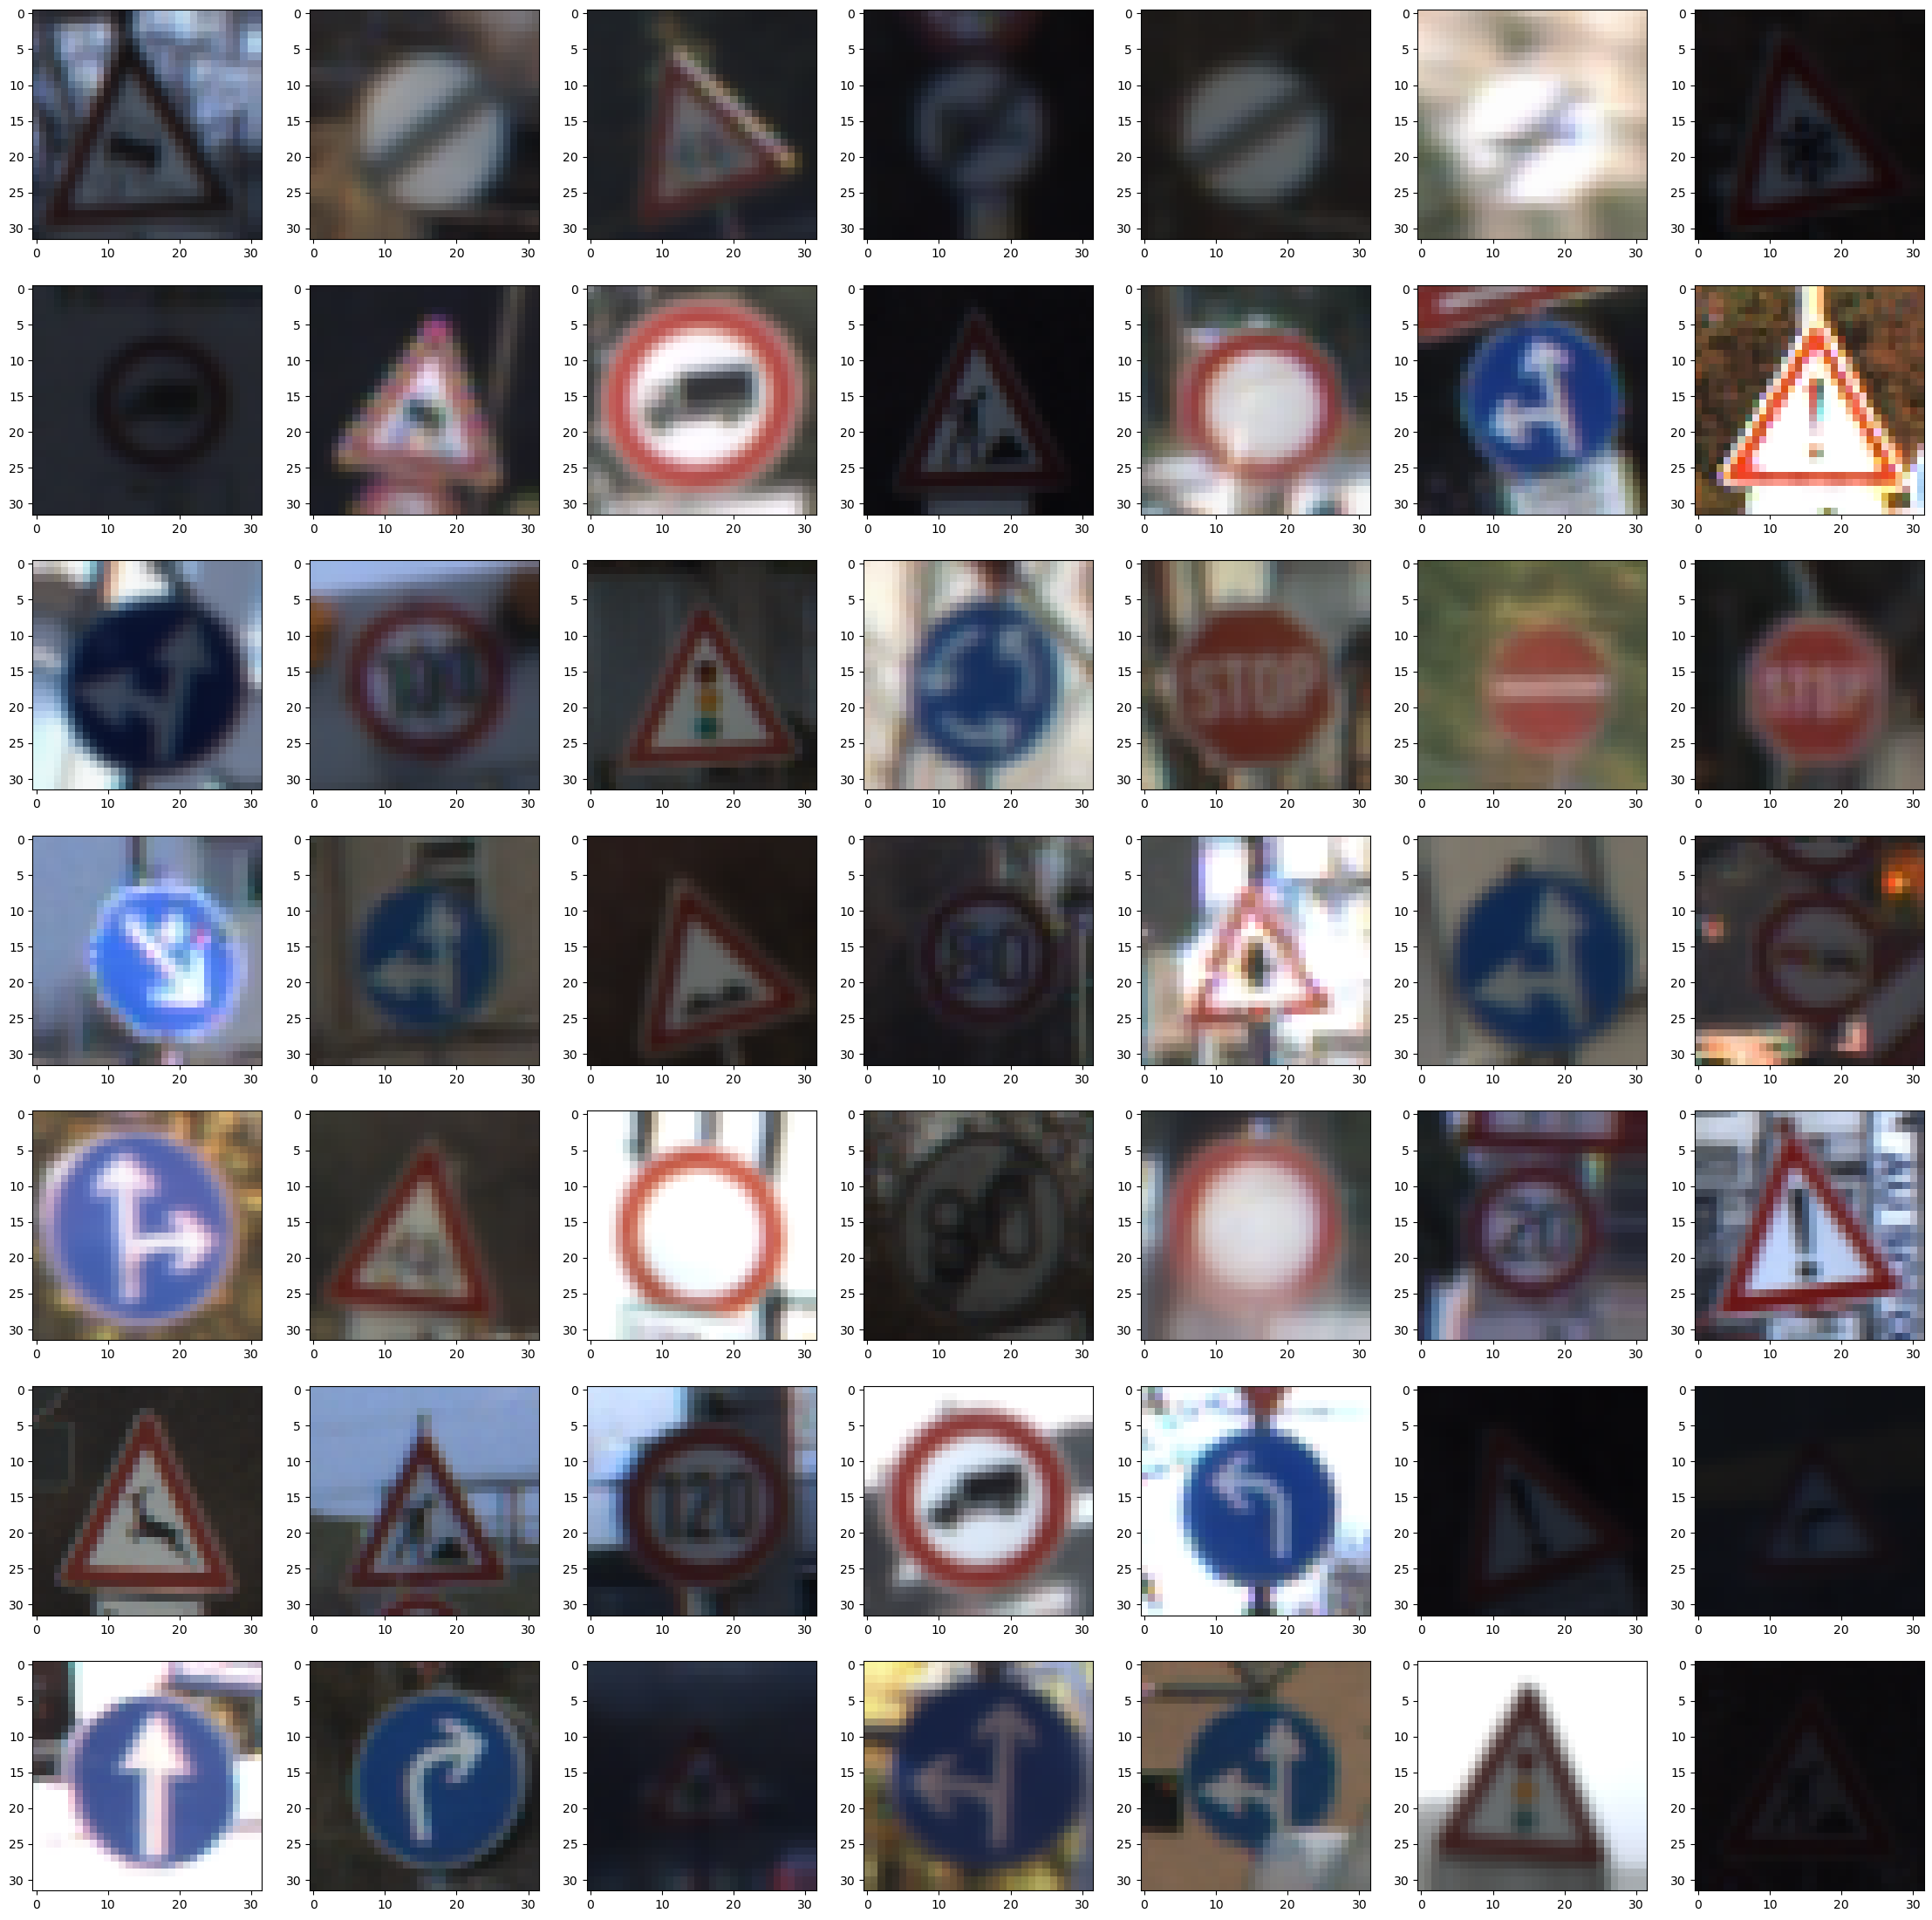

In [17]:
show_samples((7, 7), new_x)

In [18]:
x_train, y_train, x_test, y_test, x_valid, y_valid = split(new_x, new_y)
data_original = {
    "x_train": x_train,
    "y_train": y_train,
    "x_test": x_test,
    "y_test": y_test,
    "x_validation'": x_valid,
    "y_validation'": y_valid,
    "labels": labels,
}

In [19]:
with open(os.path.join(home, result_original_name), 'wb') as handle:
    pickle.dump(data_original, handle)

In [20]:
preprocessed_x = apply(new_x, hsv_eq)
preprocessed_y = keras.utils.np_utils.to_categorical(new_y).astype('float64')

In [21]:
x_train, y_train, x_test, y_test, x_valid, y_valid = split(preprocessed_x, preprocessed_y)
data_preprocessed = {
    "x_train": x_train,
    "y_train": y_train,
    "x_test": x_test,
    "y_test": y_test,
    "x_validation": x_valid,
    "y_validation": y_valid,
    "labels": labels,
}

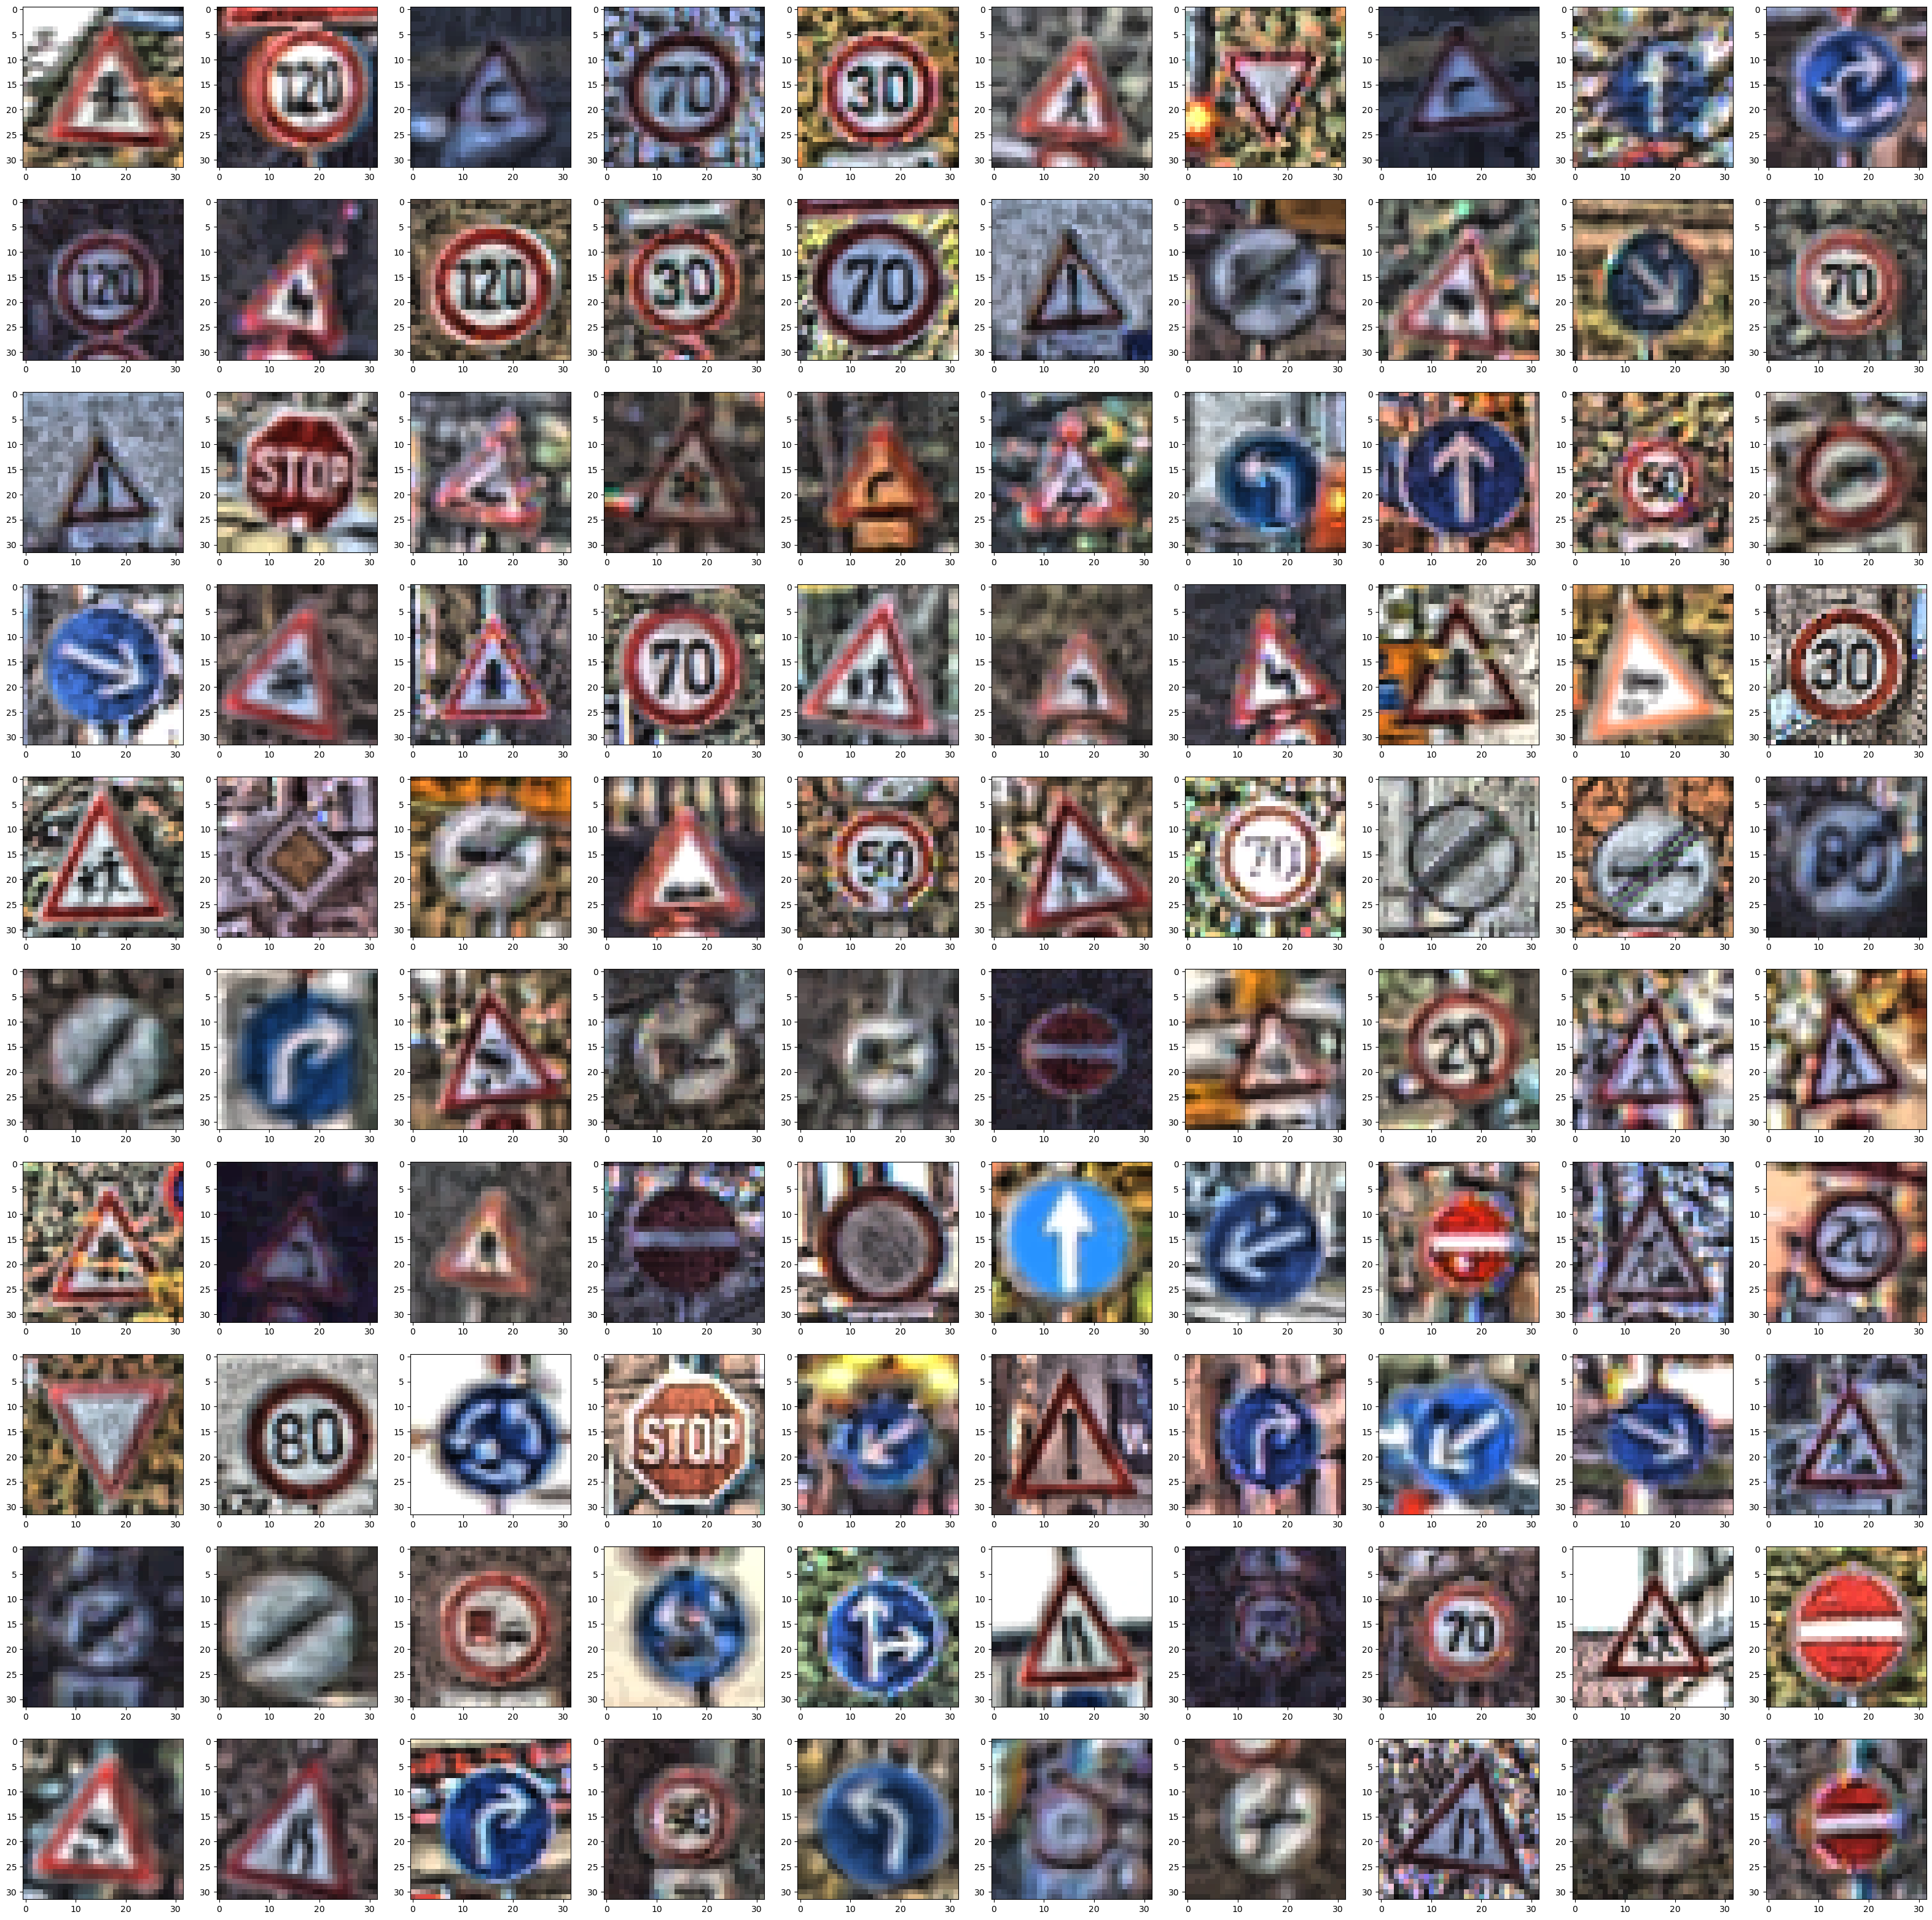

In [22]:
show_samples((10, 10), x_train)

In [23]:
with open(os.path.join(home, result_preprocessed_name), 'wb') as handle:
    pickle.dump(data_preprocessed, handle)

In [26]:
index = 0
print(x_train[index].dtype)
print(np.min(x_train[index]))
print(np.max(x_train[index]))

float32
0.07450981
1.0


In [36]:
count_classes_one_hot(y_valid, labels)

{'Speed limit (20km/h)': 108,
 'Speed limit (30km/h)': 142,
 'Speed limit (50km/h)': 109,
 'Speed limit (60km/h)': 112,
 'Speed limit (70km/h)': 120,
 'Speed limit (80km/h)': 117,
 'End of speed limit (80km/h)': 119,
 'Speed limit (100km/h)': 121,
 'Speed limit (120km/h)': 114,
 'No passing': 123,
 'No passing for vehicles over 3.5 metric tons': 107,
 'Right-of-way at the next intersection': 123,
 'Priority road': 103,
 'Yield': 102,
 'Stop': 115,
 'No vehicles': 95,
 'Vehicles over 3.5 metric tons prohibited': 120,
 'No entry': 126,
 'General caution': 115,
 'Dangerous curve to the left': 103,
 'Dangerous curve to the right': 108,
 'Double curve': 100,
 'Bumpy road': 115,
 'Slippery road': 117,
 'Road narrows on the right': 111,
 'Road work': 125,
 'Traffic signals': 125,
 'Pedestrians': 125,
 'Children crossing': 114,
 'Bicycles crossing': 103,
 'Beware of ice/snow': 114,
 'Wild animals crossing': 131,
 'End of all speed and passing limits': 103,
 'Turn right ahead': 103,
 'Turn left